In [2]:
import sys
!{sys.executable} -m pip install tabulate


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tabulate import tabulate

## Preliminary Analysis


In [4]:
file_path = 'Unipol_dataset_lab3.csv' 
data = pd.read_csv(file_path)
print(f"Number of records: {len(data)}")
unique_trips = data[['vehicle_id', 'trip_id']].drop_duplicates()
print(f"Number of unique trips: {len(unique_trips)}")
print(f"Number of unique vehicles: {data['vehicle_id'].nunique()}")

Number of records: 1415305
Number of unique trips: 966000
Number of unique vehicles: 1000


In [5]:
data.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47
2,2,1,1,2023-09-29 14:32:24,2023-09-29 14:34:31,U,0.03
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00


In [6]:
# Example: Show how trip 0 of vehicle 1 is structured
print("Example of how data is structured - Trip 0 of Vehicle 1:")
print(data[(data['vehicle_id'] == 1) & (data['trip_id'] == 0)])

Example of how data is structured - Trip 0 of Vehicle 1:
   Unnamed: 0  vehicle_id  trip_id           start_time            stop_time  \
0           0           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   
1           1           1        0  2023-09-29 13:55:35  2023-09-29 14:11:42   

  road  total_distance  
0    E           14.31  
1    U            1.47  


In [7]:
data_cleaned = data.dropna(subset=['vehicle_id', 'trip_id', 'road', 'start_time', 'stop_time', 'total_distance'])
data_cleaned['start_time'] = pd.to_datetime(data_cleaned['start_time'])
data_cleaned['stop_time'] = pd.to_datetime(data_cleaned['stop_time'])

data_cleaned['trip_duration'] = (data_cleaned['stop_time'] - data_cleaned['start_time']).dt.total_seconds() / 60.0

data_cleaned['road'] = data_cleaned['road'].replace('_', 'unknown')

print(f"Number of records after cleaning: {len(data_cleaned)}")

Number of records after cleaning: 1415305


• What is the distribution of trip distance of different types of roads? Plot ecdf and make comments.

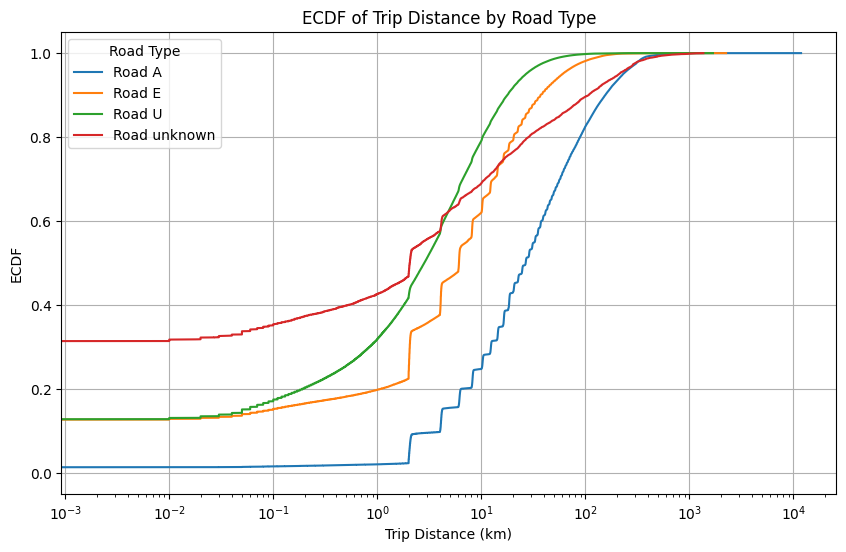

In [8]:
road_duration = data_cleaned.groupby('road')

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x)+1) / len(x)
    return x, y

# Plot ECDF for each road type
plt.figure(figsize=(10, 6))
for road, group in road_duration:
    x, y = ecdf(group['total_distance'])
    plt.semilogx(x, y, label=f'Road {road}')

# Customize the plot
plt.title('ECDF of Trip Distance by Road Type')
plt.xlabel('Trip Distance (km)')
plt.ylabel('ECDF')
plt.legend(title='Road Type')
plt.grid(True)

• What is the distribution of trip duration? Plot ecdf and make comments.

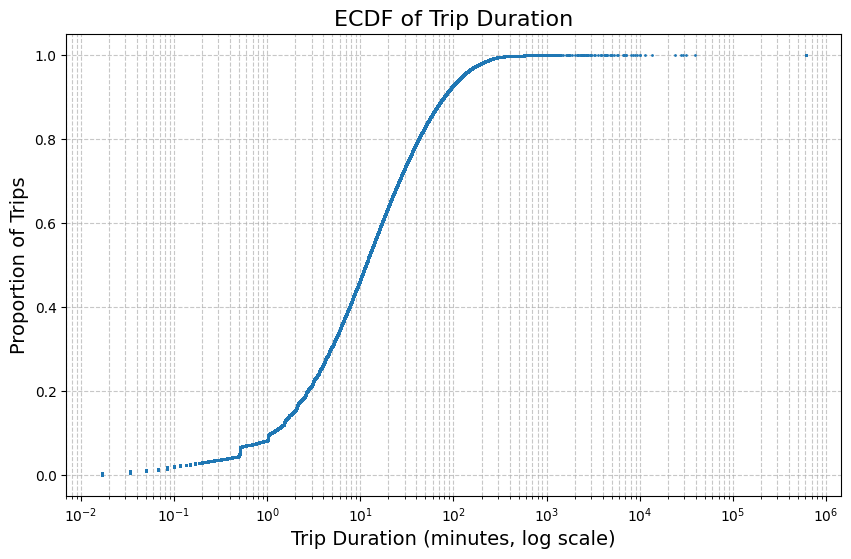

In [9]:
# Get one record per trip (duration is already calculated correctly above)
unique_trips = data_cleaned.drop_duplicates(subset=['vehicle_id', 'trip_id']).copy()

# Filter out zero/negative durations (essential for log scale)
unique_trips = unique_trips[unique_trips['trip_duration'] > 0]

def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

plt.figure(figsize=(10, 6))

x, y = ecdf(unique_trips['trip_duration'])

# Plotting
plt.plot(x, y, marker='.', linestyle='none', markersize=2) 

plt.title('ECDF of Trip Duration', fontsize=16)
plt.xlabel('Trip Duration (minutes, log scale)', fontsize=14)
plt.ylabel('Proportion of Trips', fontsize=14)
plt.grid(True, which='both', linestyle='--', alpha=0.7)

# Set Log Scale
plt.xscale('log')

plt.show()

• What is the relationship between trip duration and distance? Can you spot any difference among
trips with different road types?


Number of pure trips before filtering: 639971
Number of pure trips after filtering: 419635
Removed 220336 pure trips based on filtering criteria.


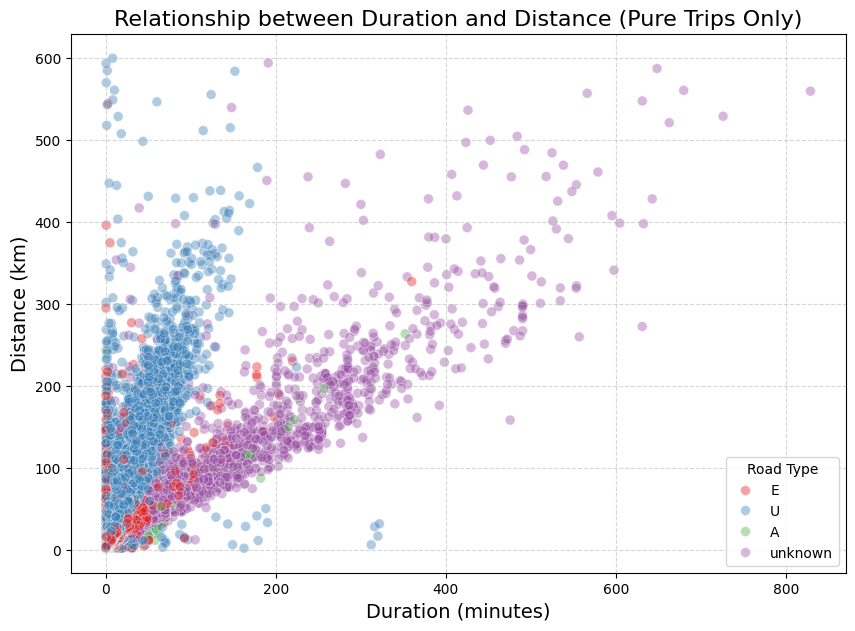

In [10]:
# Filter for "Pure" Trips (Trips with only 1 road segment)
# We group by Trip ID and keep only groups with exactly 1 row.
# This removes "Mixed" trips (e.g., Urban + Highway) where data is misleading.
trip_counts = data_cleaned.groupby(['vehicle_id', 'trip_id']).size()
pure_trip_indices = trip_counts[trip_counts == 1].index

# Select these trips from the main dataframe
pure_trips = data_cleaned.set_index(['vehicle_id', 'trip_id']).loc[pure_trip_indices].reset_index()

# Define filtering criteria
min_distance = 0.1
max_distance = 1000
min_duration = 2
max_duration = 600
min_speed = 1
max_speed = 200

number_of_pure_trips_before = len(pure_trips)
print(f"Number of pure trips before filtering: {number_of_pure_trips_before}")

# Filter for reasonable limits to make the plot readable (remove extreme outliers)
pure_trips = pure_trips[
    (pure_trips['total_distance'] > min_distance) &
    (pure_trips['total_distance'] <= max_distance) &
    (pure_trips['trip_duration'] > min_duration) &
    (pure_trips['trip_duration'] <= max_duration)
].copy()

print(f"Number of pure trips after filtering: {len(pure_trips)}")
# count the number of pure trips removed
print(f"Removed {number_of_pure_trips_before - len(pure_trips)} pure trips based on filtering criteria.")

# Plot Scatter Graph
plt.figure(figsize=(10, 7))

sns.scatterplot(
    data=pure_trips, 
    x='total_distance', 
    y='trip_duration',
    hue='road', 
    alpha=0.4, 
    palette='Set1',
    s=50       
)

plt.title('Relationship between Duration and Distance (Pure Trips Only)', fontsize=16)
plt.xlabel('Duration (minutes)', fontsize=14)
plt.ylabel('Distance (km)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title='Road Type')

plt.show()

In [11]:
# Filter dataset: Remove rows with zero or negative distance/duration
filtered_data = data_cleaned[
    (data_cleaned['total_distance'] > min_distance) &
    (data_cleaned['total_distance'] <= max_distance) &
    (data_cleaned['trip_duration'] > min_duration) &
    (data_cleaned['trip_duration'] <= max_duration)
].copy()  # Use .copy() to avoid SettingWithCopyWarning

# Calculate average speed (km/h) and filter based on speed thresholds
filtered_data['average_speed'] = (
    filtered_data['total_distance'] / (filtered_data['trip_duration'] / 60)
)

filtered_data = filtered_data[
    (filtered_data['average_speed'] >= min_speed) &
    (filtered_data['average_speed'] <= max_speed)
]

# Count the number of valid trips
valid_trip_count = len(filtered_data)

# Display the filtering criteria and valid trip count
print("Filtering Criteria:")
print(f"1. Total distance > {min_distance} km and ≤ {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and ≤ {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

Filtering Criteria:
1. Total distance > 0.1 km and ≤ 1000 km
2. Trip duration > 2 minutes and ≤ 600 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 1149664


In [12]:
filtered_data.head()

,Unnamed: 0,vehicle_id,trip_id,start_time,stop_time,road,total_distance,trip_duration,average_speed
0,0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,E,14.31,16.116667,53.274043
1,1,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,U,1.47,16.116667,5.472596
3,3,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,E,2.60,14.866667,10.493274
4,4,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,U,2.00,14.866667,8.071749
5,5,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,E,2.24,19.800000,6.787879


/home/cavallinux/Backup/Magistrale/ICT4SmartMobility/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


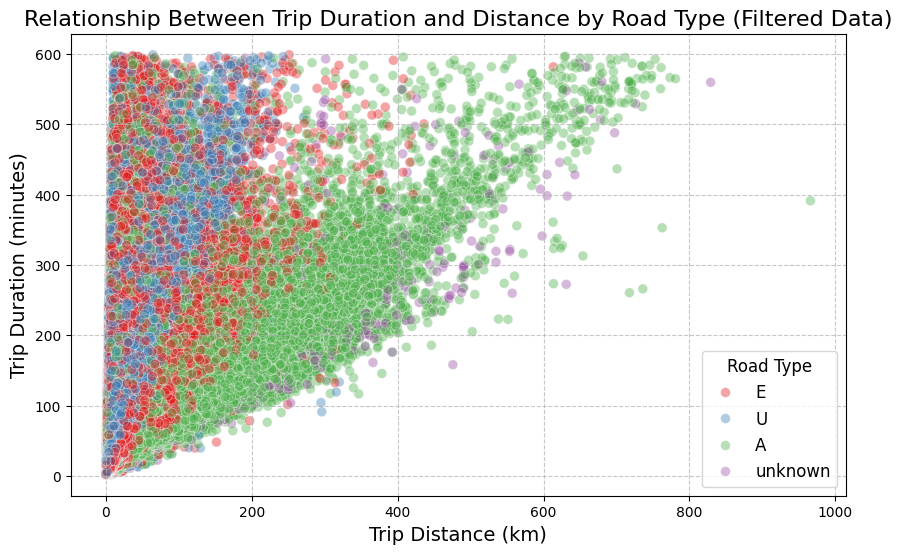

In [13]:
# Scatter plot with regression lines for each road type (filtered data)
plt.figure(figsize=(10, 6))

# Scatter points
sns.scatterplot(
    data=filtered_data,
    x='total_distance',
    y='trip_duration',
    hue='road',
    palette='Set1',
    s=50,        # marker size
    alpha=0.4
)

# Customize the plot
plt.title('Relationship Between Trip Duration and Distance by Road Type (Filtered Data)', fontsize=16)
plt.xlabel('Trip Distance (km)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.legend(title='Road Type', fontsize=12, title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Display the plot
plt.show()

• Filter the dataset, remove outliers (e.g. distance 0, impossible distance wrt duration) and report your
filter criteria. How many valid trips are recorded in the dataset?

In [14]:
print(f"Number of records before filtering: {len(data_cleaned)}")

# Aggregate at trip level first since each row is a road segment
# Sum up the distances from all road segments to get total trip distance
trips_aggregated = data_cleaned.groupby(['vehicle_id', 'trip_id']).agg({
    'start_time': 'first',         # Same for all segments in a trip
    'stop_time': 'first',           # Same for all segments in a trip
    'total_distance': 'sum',        # Sum distances across all road segments
    'trip_duration': 'first'        # Same for all segments in a trip (already calculated)
}).reset_index()

# Filter dataset based on TRIP-level metrics
filtered_trips = trips_aggregated[
    (trips_aggregated['total_distance'] > min_distance) &
    (trips_aggregated['total_distance'] <= max_distance) &
    (trips_aggregated['trip_duration'] > min_duration) &
    (trips_aggregated['trip_duration'] <= max_duration)
].copy()

# Calculate average speed using TOTAL trip distance and TOTAL trip duration
filtered_trips['average_speed'] = (
    filtered_trips['total_distance'] / (filtered_trips['trip_duration'] / 60)
)

# Filter based on speed
filtered_trips = filtered_trips[
    (filtered_trips['average_speed'] >= min_speed) &
    (filtered_trips['average_speed'] <= max_speed)
]

# Count valid trips
valid_trip_count = len(filtered_trips)

print("Filtering Criteria:")
print(f"1. Total trip distance > {min_distance} km and <= {max_distance} km")
print(f"2. Trip duration > {min_duration} minutes and <= {max_duration} minutes")
print(f"3. Average speed between {min_speed} km/h and {max_speed} km/h")
print(f"Number of valid trips: {valid_trip_count}")

Number of records before filtering: 1415305
Filtering Criteria:
1. Total trip distance > 0.1 km and <= 1000 km
2. Trip duration > 2 minutes and <= 600 minutes
3. Average speed between 1 km/h and 200 km/h
Number of valid trips: 739862


In [15]:
filtered_trips['date'] = filtered_trips['start_time'].dt.date
filtered_trips['day_type'] = filtered_trips['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [16]:
filtered_trips

,vehicle_id,trip_id,start_time,stop_time,total_distance,trip_duration,average_speed,date,day_type
0,1,0,2023-09-29 13:55:35,2023-09-29 14:11:42,15.78,16.116667,58.746639,2023-09-29,Weekday
2,1,2,2023-09-29 15:12:03,2023-09-29 15:26:55,4.60,14.866667,18.565022,2023-09-29,Weekday
3,1,3,2023-09-29 15:37:38,2023-09-29 15:57:26,4.25,19.800000,12.878788,2023-09-29,Weekday
6,1,6,2023-09-30 05:05:39,2023-09-30 05:28:37,1.21,22.966667,3.161103,2023-09-30,Weekend
8,1,8,2023-09-30 06:07:07,2023-09-30 06:33:53,5.08,26.766667,11.387298,2023-09-30,Weekend
...,...,...,...,...,...,...,...,...,...
965991,1000,470,2023-11-26 16:27:39,2023-11-27 00:13:05,31.58,465.433333,4.071045,2023-11-26,Weekend
965992,1000,471,2023-11-27 11:40:36,2023-11-27 14:10:15,20.72,149.650000,8.307384,2023-11-27,Weekday
965993,1000,472,2023-11-27 17:14:33,2023-11-28 00:07:48,18.70,413.250000,2.715064,2023-11-27,Weekday
965994,1000,473,2023-11-28 09:17:51,2023-11-28 13:06:43,84.30,228.866667,22.100204,2023-11-28,Weekday


In [17]:
# aggregate data on daily basis for each vehicle and road type
daily_aggregation = filtered_trips.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_distance=('total_distance', 'sum'),   # compute total distance by summing up distances
    total_trip_duration=('trip_duration', 'sum'),   # compute total trip duration by summing up durations
    num_trips=('trip_id', 'nunique')    # count unique trips id
).reset_index()

# evaluate daily utilization of each vehicle
daily_aggregation['daily_utilization'] = daily_aggregation.groupby(['vehicle_id', 'date'])['total_trip_duration'].transform('sum') / (24 * 60)  # 24 hours

In [18]:
daily_aggregation

,vehicle_id,date,day_type,total_distance,total_trip_duration,num_trips,daily_utilization
0,1,2023-09-29,Weekday,24.630,50.783333,3,0.035266
1,1,2023-09-30,Weekend,11.030,67.333333,5,0.046759
2,1,2023-10-01,Weekend,361.539,268.983333,1,0.186794
3,1,2023-10-02,Weekday,725.195,562.733333,7,0.390787
4,1,2023-10-03,Weekday,519.450,477.033333,7,0.331273
...,...,...,...,...,...,...,...
55263,1000,2023-11-20,Weekday,12.860,252.316667,1,0.175220
55264,1000,2023-11-24,Weekday,11.000,155.566667,1,0.108032
55265,1000,2023-11-26,Weekend,31.580,465.433333,1,0.323218
55266,1000,2023-11-27,Weekday,39.420,562.900000,2,0.390903


**1.a.** Compute the statistics and distribution of the values on workdays and weekends/holidays.
Can you find any difference? Can you find some vehicles behave consistently?

In [19]:
# extract the amount of total trips during weekdays and weekends
fraction_data = daily_aggregation.groupby(['vehicle_id', 'day_type'], as_index=False).agg(
    num_trips=('num_trips', 'sum'),
    average_trip_duration=('total_trip_duration', 'mean'),
)

# Calculate fraction per vehicle and day type (normalize within each day_type group)
fraction_data['fraction'] = fraction_data.groupby('day_type')['num_trips'].transform(lambda x: x / x.sum())

In [20]:
fraction_data

,vehicle_id,day_type,num_trips,average_trip_duration,fraction
0,1,Weekday,357,504.097037,0.000622
1,1,Weekend,49,243.045833,0.000295
2,2,Weekday,221,659.347348,0.000385
3,2,Weekend,18,416.623333,0.000108
4,3,Weekday,288,609.226829,0.000502
...,...,...,...,...,...
1987,998,Weekend,124,272.315278,0.000746
1988,999,Weekday,1157,610.135606,0.002017
1989,999,Weekend,329,447.973529,0.001980
1990,1000,Weekday,357,436.180702,0.000622


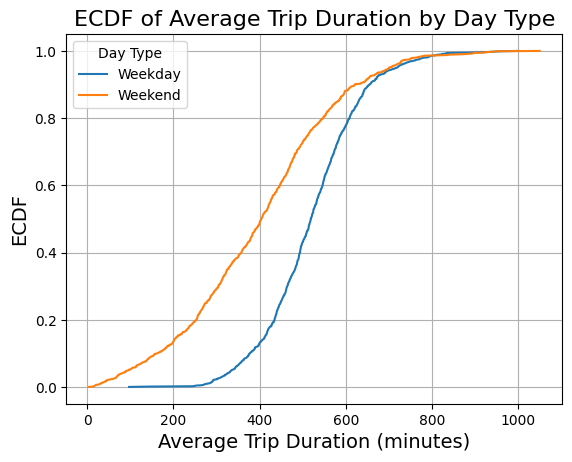

In [44]:
# Similar to your existing ecdf function
for day_type in ['Weekday', 'Weekend']:
    subset = fraction_data[fraction_data['day_type'] == day_type]
    x, y = ecdf(subset['average_trip_duration'])
    plt.plot(x, y, label=day_type)
plt.title('ECDF of Average Trip Duration by Day Type', fontsize=16)
plt.xlabel('Average Trip Duration (minutes)', fontsize=14)
plt.ylabel('ECDF', fontsize=14)
plt.legend(title='Day Type')
plt.grid(True)
plt.show()

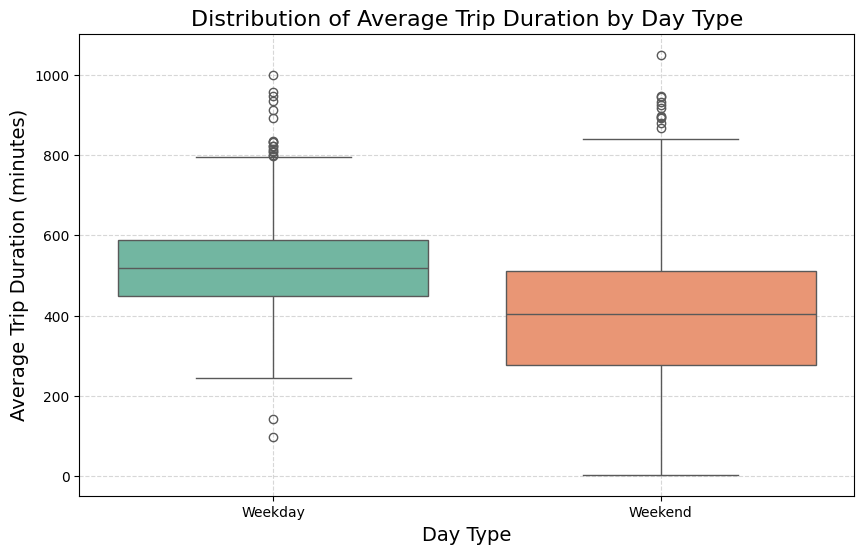

In [22]:
# plot vehicle distribution of average_trip_duration

plt.figure(figsize=(10, 6))
sns.boxplot(
    data=fraction_data,
    x='day_type',
    y='average_trip_duration',
    hue='day_type',
    palette='Set2'
)
plt.title('Distribution of Average Trip Duration by Day Type', fontsize=16)
plt.xlabel('Day Type', fontsize=14)
plt.ylabel('Average Trip Duration (minutes)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

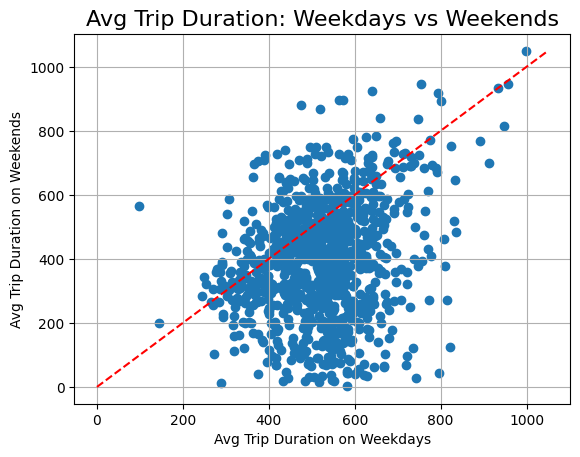

In [ ]:
# Pivot to get weekday/weekend columns
pivot = fraction_data.pivot(index='vehicle_id', columns='day_type', values='average_trip_duration')

# Scatter plot
plt.scatter(pivot['Weekday'], pivot['Weekend'])
# diagonal line
max_val = max(pivot['Weekday'].max(), pivot['Weekend'].max())
plt.plot([0, max_val], [0, max_val], color='red', linestyle='--')
plt.xlabel('Avg Trip Duration on Weekdays')
plt.ylabel('Avg Trip Duration on Weekends')
plt.title('Avg Trip Duration: Weekdays vs Weekends', fontsize=16)
plt.grid(True)
plt.show()

# more points below the diagonal line means vehicles tend to have longer trips on weekdays

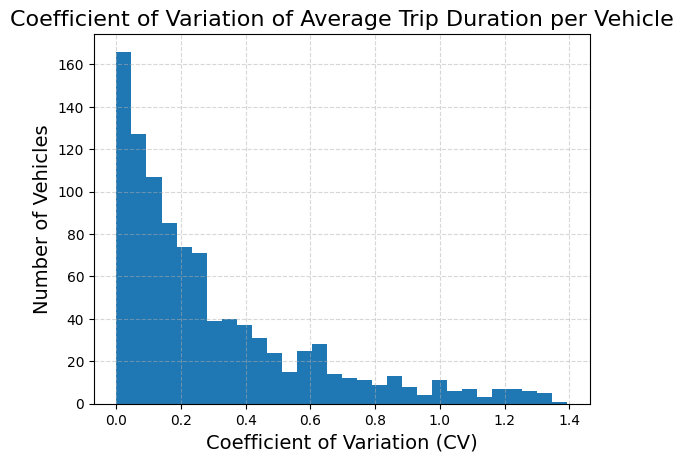

In [ ]:
vehicle_consistency = fraction_data.groupby('vehicle_id').agg({
    'average_trip_duration': ['mean', 'std']
})
vehicle_consistency['cv'] = vehicle_consistency[('average_trip_duration', 'std')] / vehicle_consistency[('average_trip_duration', 'mean')]

# Plot CV distribution or bar chart of most/least consistent
plt.hist(vehicle_consistency['cv'], bins=30)
plt.title('Coefficient of Variation of Average Trip Duration per Vehicle', fontsize=16)
plt.xlabel('Coefficient of Variation (CV)', fontsize=14)
plt.ylabel('Number of Vehicles', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

# low CV means more consistent

In [61]:
daily_data = daily_aggregation.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_distance =('total_distance', 'sum'),
    total_trip_duration =('total_trip_duration', 'sum'),
    num_trips =('num_trips', 'sum')
).reset_index()

In [62]:
daily_data

,vehicle_id,date,day_type,total_distance,total_trip_duration,num_trips
0,1,2023-09-29,Weekday,24.630,50.783333,3
1,1,2023-09-30,Weekend,11.030,67.333333,5
2,1,2023-10-01,Weekend,361.539,268.983333,1
3,1,2023-10-02,Weekday,725.195,562.733333,7
4,1,2023-10-03,Weekday,519.450,477.033333,7
...,...,...,...,...,...,...
55263,1000,2023-11-20,Weekday,12.860,252.316667,1
55264,1000,2023-11-24,Weekday,11.000,155.566667,1
55265,1000,2023-11-26,Weekend,31.580,465.433333,1
55266,1000,2023-11-27,Weekday,39.420,562.900000,2


In [63]:
statistics = daily_data.groupby('day_type').agg(
    avg_distance=('total_distance', 'mean'),
    std_distance=('total_distance', 'std'),
    min_distance=('total_distance', 'min'),
    max_distance=('total_distance', 'max'),
    avg_duration=('total_trip_duration', 'mean'),
    std_duration=('total_trip_duration', 'std'),
    min_duration=('total_trip_duration', 'min'),
    max_duration=('total_trip_duration', 'max'),
    avg_trips=('num_trips', 'mean'),
    std_trips=('num_trips', 'std'),
    min_trips=('num_trips', 'min'),
    max_trips=('num_trips', 'max')
).reset_index()

In [64]:
statistics

,day_type,avg_distance,std_distance,min_distance,max_distance,avg_duration,std_duration,min_duration,max_duration,avg_trips,std_trips,min_trips,max_trips
0,Weekday,391.018840,248.204546,0.110,2112.930,522.476173,218.753963,2.083333,1545.150000,13.826665,10.036910,1,114
1,Weekend,300.626731,220.709658,0.102,2046.935,429.423712,259.786550,2.016667,1755.883333,12.061992,10.438596,1,93


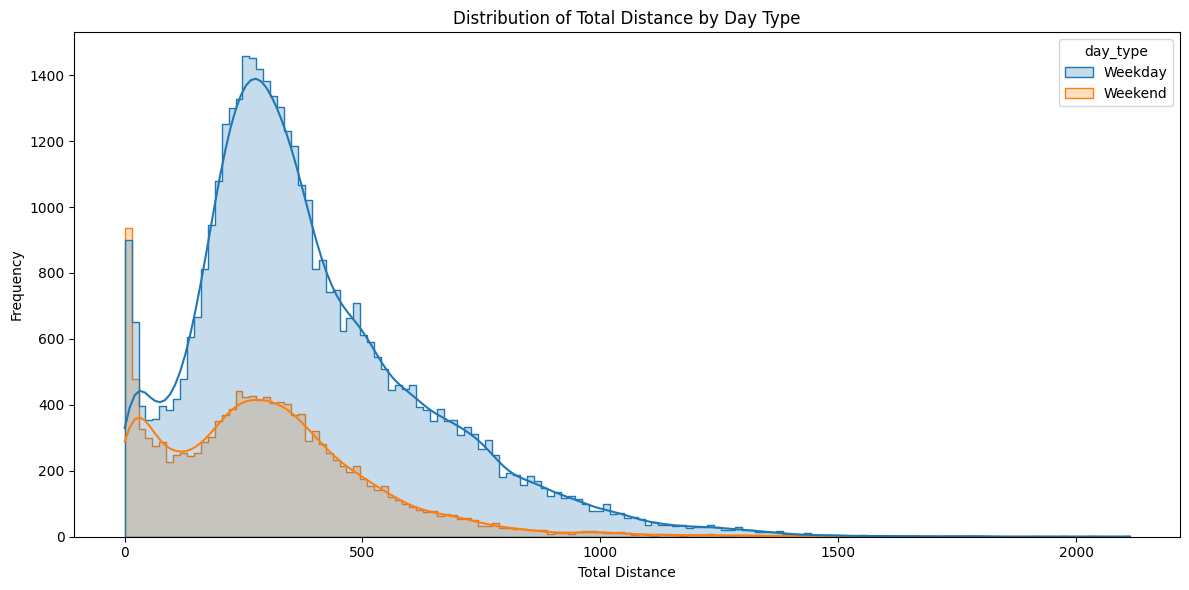

In [36]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_distance', hue='day_type', kde=True, element='step')
plt.title('Distribution of Total Distance by Day Type')
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

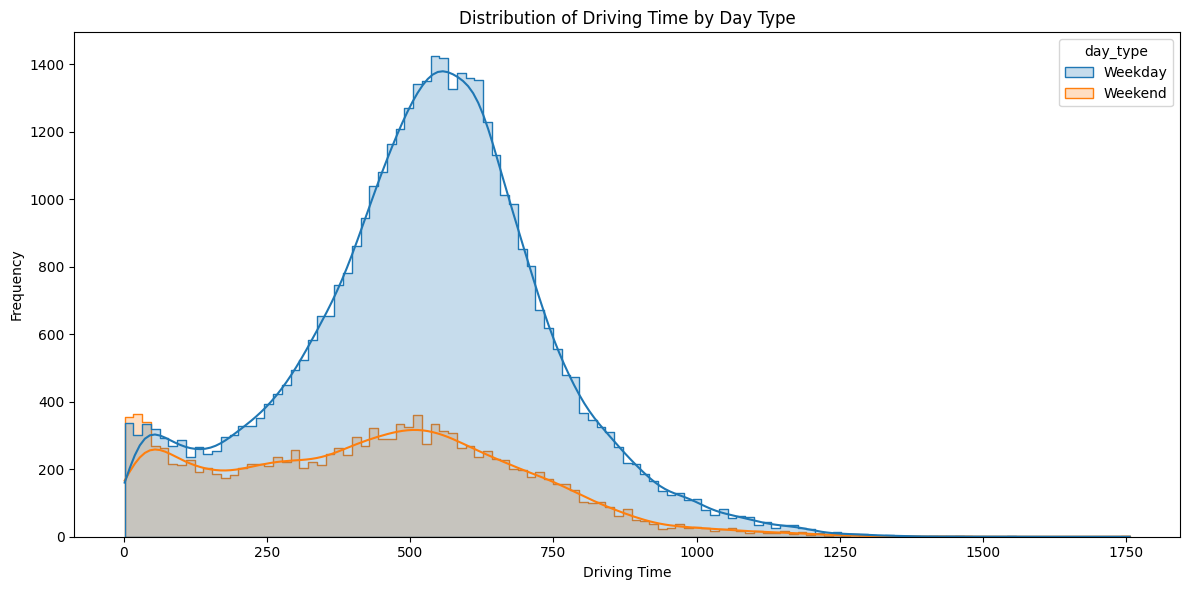

In [37]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='total_trip_duration', hue='day_type', kde=True, element='step')
plt.title('Distribution of Driving Time by Day Type')
plt.xlabel('Driving Time')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

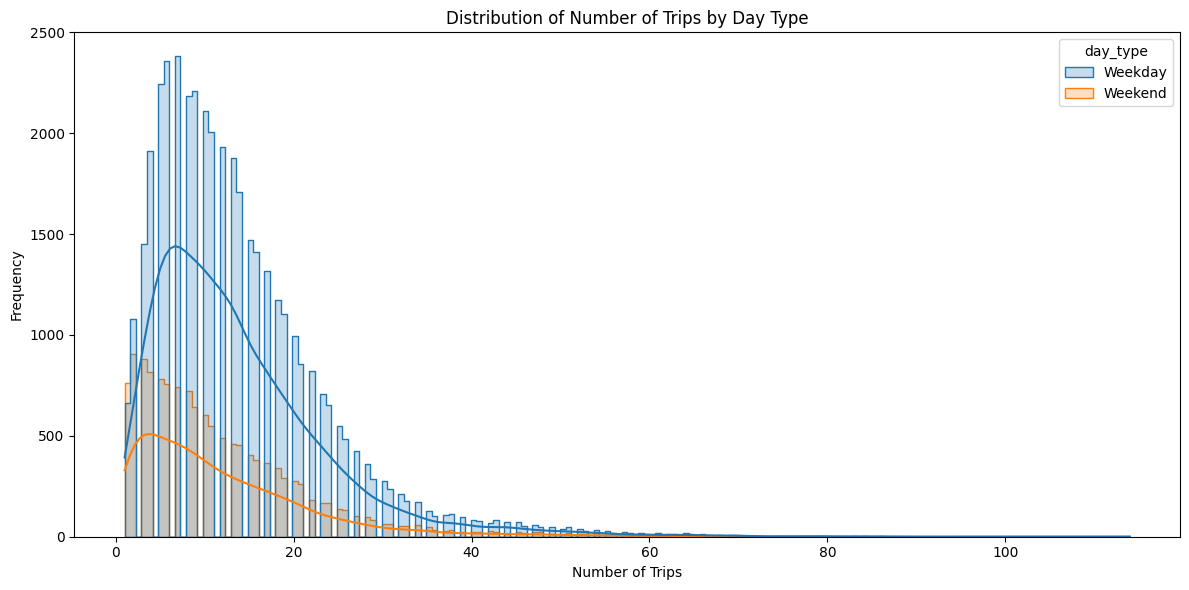

In [38]:
plt.figure(figsize=(12, 6))
sns.histplot(data=daily_data, x='num_trips', hue='day_type', kde=True, element='step')
plt.title('Distribution of Number of Trips by Day Type')
plt.xlabel('Number of Trips')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**1.b.** For each vehicle, compute the fraction of its trips with different road types. Choose a
meaningful way to show the results and make comments.

In [65]:
# Add date and day_type to filtered_data (which contains road segments)
filtered_data['date'] = filtered_data['start_time'].dt.date
filtered_data['day_type'] = filtered_data['start_time'].dt.weekday.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

In [66]:
# Aggregate by vehicle, date, day_type, AND road type
# Since each row is a road segment, we can sum distance per road type
daily_aggregation_data = filtered_data.groupby(['vehicle_id', 'date', 'day_type', 'road']).agg(
    total_distance=('total_distance', 'sum'),   # sum segment distances per road type
    num_trips=('trip_id', 'nunique')    # count unique trips per road type
).reset_index()

# For trip duration and utilization, we need trip-level data (not segment-level)
trip_level_data = filtered_data.groupby(['vehicle_id', 'trip_id', 'date', 'day_type']).agg({
    'trip_duration': 'first',  # Same for all segments
    'start_time': 'first',
    'stop_time': 'first'
}).reset_index()

# Calculate daily utilization based on trip-level data
daily_utilization = trip_level_data.groupby(['vehicle_id', 'date', 'day_type']).agg(
    total_trip_duration=('trip_duration', 'sum')
).reset_index()
daily_utilization['daily_utilization'] = daily_utilization['total_trip_duration'] / (24 * 60)

# Merge utilization back to daily_aggregation_data
daily_aggregation_data = daily_aggregation_data.merge(
    daily_utilization[['vehicle_id', 'date', 'day_type', 'total_trip_duration', 'daily_utilization']], 
    on=['vehicle_id', 'date', 'day_type'], 
    how='left'
)

# compute trip counts per vehicle and road type
trip_counts = daily_aggregation_data.groupby(['vehicle_id', 'road'])['num_trips'].sum().reset_index()

# compute total trips per vehicle
total_trips = daily_aggregation_data.groupby('vehicle_id')['num_trips'].sum().reset_index()
total_trips.rename(columns={'num_trips': 'total_trips'}, inplace=True)

# merge trip counts with total trips to compute fractions
vehicle_road_fraction = pd.merge(trip_counts, total_trips, on='vehicle_id')
vehicle_road_fraction['fraction'] = vehicle_road_fraction['num_trips'] / vehicle_road_fraction['total_trips']

In [67]:
vehicle_road_fraction

,vehicle_id,road,num_trips,total_trips,fraction
0,1,A,149,703,0.211949
1,1,E,341,703,0.485064
2,1,U,213,703,0.302987
3,2,A,140,492,0.284553
4,2,E,207,492,0.420732
...,...,...,...,...,...
3182,999,E,185,1841,0.100489
3183,999,U,1482,1841,0.804997
3184,1000,A,51,767,0.066493
3185,1000,E,375,767,0.488918


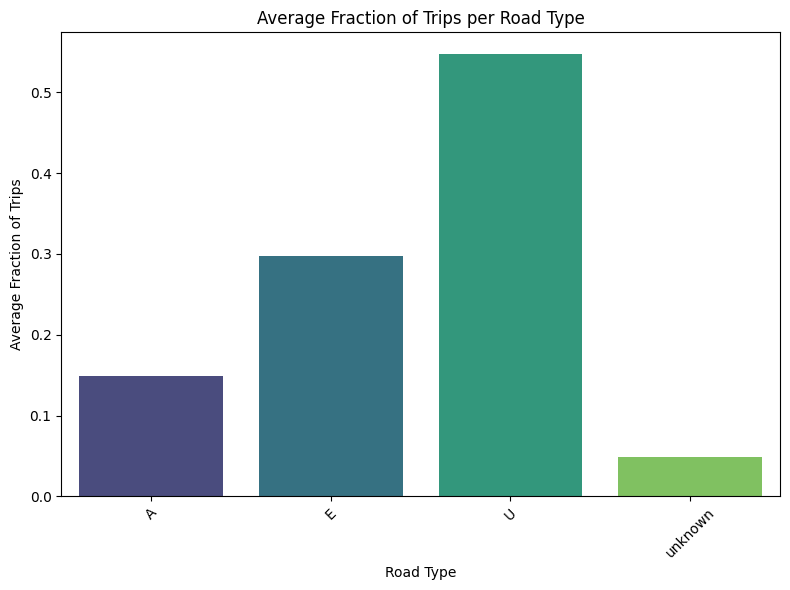

In [68]:
average_fraction = vehicle_road_fraction.groupby('road')['fraction'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=average_fraction, x='road', y='fraction', hue='road', palette='viridis')
plt.title('Average Fraction of Trips per Road Type')
plt.xlabel('Road Type')
plt.ylabel('Average Fraction of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

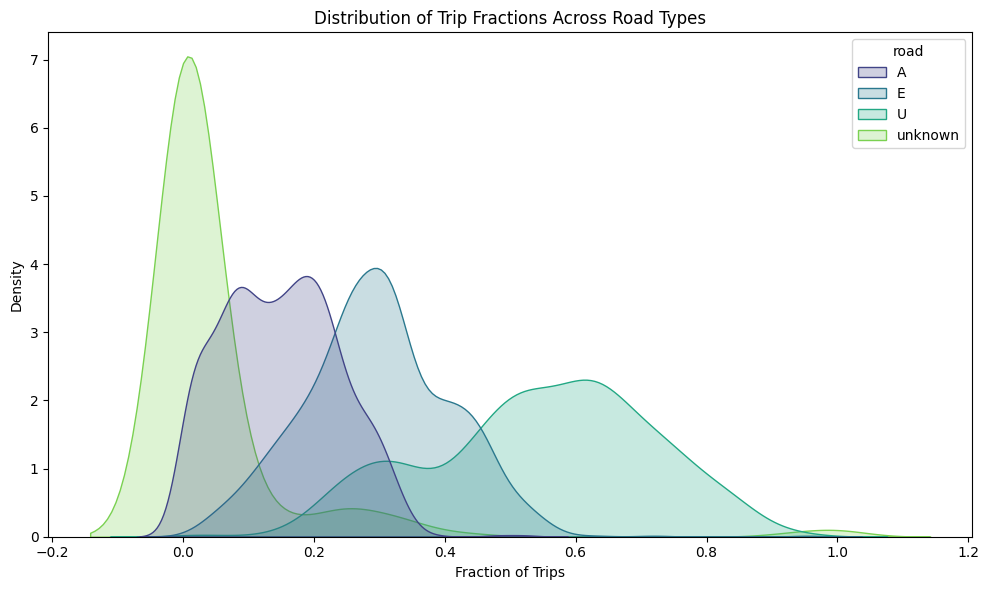

In [69]:
plt.figure(figsize=(10, 6))
sns.kdeplot(data=vehicle_road_fraction, x='fraction', hue='road', fill=True, common_norm=False, palette='viridis')
plt.title('Distribution of Trip Fractions Across Road Types')
plt.xlabel('Fraction of Trips')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

**1.c.** According to the characters you find, categorize and cluster the vehicles into 3-5 types based on their behaviours.

In [71]:
vehicle_road = daily_aggregation_data.groupby(['vehicle_id', 'road']).agg(
    total_distance=('total_distance', 'sum'),
    daily_utilization=('daily_utilization', 'mean')
).reset_index()

In [74]:
daily_aggregation_data

,vehicle_id,date,day_type,road,total_distance,num_trips,total_trip_duration,daily_utilization
0,1,2023-09-29,Weekday,E,19.150,3,50.783333,0.035266
1,1,2023-09-29,Weekday,U,5.480,3,50.783333,0.035266
2,1,2023-09-30,Weekend,E,6.130,3,67.333333,0.046759
3,1,2023-09-30,Weekend,U,4.900,4,67.333333,0.046759
4,1,2023-10-01,Weekend,A,200.989,1,268.983333,0.186794
...,...,...,...,...,...,...,...,...
148635,1000,2023-11-27,Weekday,A,12.410,1,562.900000,0.390903
148636,1000,2023-11-27,Weekday,U,18.790,2,562.900000,0.390903
148637,1000,2023-11-28,Weekday,A,20.520,1,250.683333,0.174086
148638,1000,2023-11-28,Weekday,E,48.460,2,250.683333,0.174086


In [72]:
vehicle_road

,vehicle_id,road,total_distance,daily_utilization
0,1,A,16499.866,0.351646
1,1,E,8970.230,0.311307
2,1,U,972.750,0.328262
3,2,A,25836.080,0.461543
4,2,E,6683.460,0.440680
...,...,...,...,...
3182,999,E,1252.870,0.414573
3183,999,U,11824.060,0.392321
3184,1000,A,3641.050,0.344209
3185,1000,E,7362.370,0.279580


In [75]:
# Create separate DataFrames for distance and utilization, then merge
distance_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='total_distance'
).add_prefix('total_distance_road_').fillna(0)

utilization_pivot = vehicle_road.pivot(
    index='vehicle_id',
    columns='road',
    values='daily_utilization'
).add_prefix('daily_utilization_road_').fillna(0)

# Merge the two pivoted DataFrames
vehicle_data = distance_pivot.join(utilization_pivot).reset_index()

In [76]:
# normalize the features for clustering
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
road_features = [col for col in vehicle_data.columns if 'total_distance' in col]
utilization_feature = [col for col in vehicle_data.columns if 'daily_utilization' in col]
features = road_features + utilization_feature
selected_data = vehicle_data[features]
vehicle_data[features] = scaler.fit_transform(vehicle_data[features])

In [77]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
0,1,1.042278,0.974481,-1.298045,-0.16262,-0.288883,-0.636432,-0.255493,-0.48282
1,2,2.269320,0.332318,-1.280515,-0.16262,0.961044,1.022216,1.252949,-0.48282
2,3,1.710082,0.402424,-1.198255,-0.16262,1.202395,0.746614,0.824367,-0.48282
3,4,-1.108702,0.308291,0.493961,-0.16262,-0.792356,-0.941150,-0.973635,-0.48282
4,5,1.858704,0.995741,-1.212821,-0.16262,1.299168,0.885694,0.831648,-0.48282
...,...,...,...,...,...,...,...,...,...
994,996,0.597271,-0.263570,-1.291406,-0.16262,0.595546,-0.251353,-0.060995,-0.48282
995,997,0.612010,1.026932,-1.337150,-0.16262,0.615270,-0.076822,0.299089,-0.48282
996,998,-0.072999,0.451665,-0.268187,-0.16262,-0.660389,-0.254738,-0.837553,-0.48282
997,999,-0.792220,-1.192683,1.531276,-0.16262,0.388076,0.687502,0.582570,-0.48282


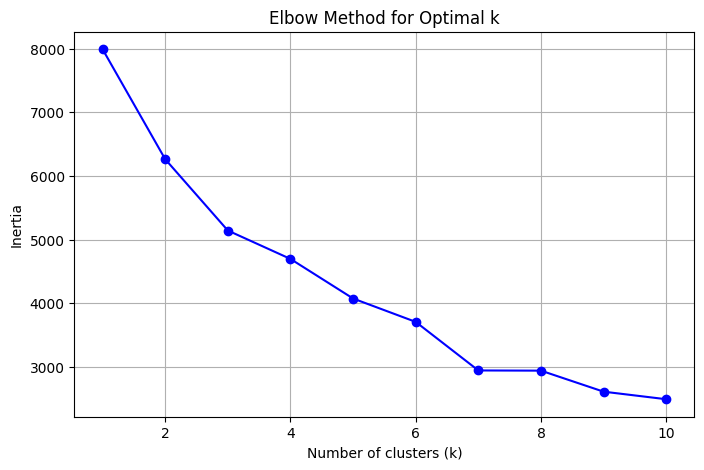

In [78]:
# use K-means to cluster vehicles based on their road usage patterns
from sklearn.cluster import KMeans

inertia = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(vehicle_data[features])
    inertia.append(kmeans.inertia_)

# plot the elbow method
plt.figure(figsize=(8, 5))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()

In [79]:
n_clusters = 4  # choose based on elbow method
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
vehicle_data['cluster'] = kmeans.fit_predict(vehicle_data[features])

In [80]:
vehicle_data

road,vehicle_id,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown,cluster
0,1,1.042278,0.974481,-1.298045,-0.16262,-0.288883,-0.636432,-0.255493,-0.48282,1
1,2,2.269320,0.332318,-1.280515,-0.16262,0.961044,1.022216,1.252949,-0.48282,1
2,3,1.710082,0.402424,-1.198255,-0.16262,1.202395,0.746614,0.824367,-0.48282,1
3,4,-1.108702,0.308291,0.493961,-0.16262,-0.792356,-0.941150,-0.973635,-0.48282,0
4,5,1.858704,0.995741,-1.212821,-0.16262,1.299168,0.885694,0.831648,-0.48282,1
...,...,...,...,...,...,...,...,...,...,...
994,996,0.597271,-0.263570,-1.291406,-0.16262,0.595546,-0.251353,-0.060995,-0.48282,1
995,997,0.612010,1.026932,-1.337150,-0.16262,0.615270,-0.076822,0.299089,-0.48282,1
996,998,-0.072999,0.451665,-0.268187,-0.16262,-0.660389,-0.254738,-0.837553,-0.48282,0
997,999,-0.792220,-1.192683,1.531276,-0.16262,0.388076,0.687502,0.582570,-0.48282,2


In [81]:
clusters = vehicle_data.groupby('cluster')[features].mean()

In [82]:
clusters

road,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
cluster,,,,,,,,
0,-0.105678,0.135908,-0.564016,0.199492,-0.967132,-1.129455,-1.136435,-0.016849
1,1.200540,0.535539,-0.966775,0.060104,0.380389,0.307384,0.412909,0.541719
2,-0.580679,-0.535361,1.313504,-0.097826,1.206294,1.365367,1.322419,-0.116357
3,-0.543802,-0.252490,0.537238,-0.153436,-0.112584,-0.007650,-0.061119,-0.339103


In [83]:
# rescale back the cluster centers to original scale
clusters_rescaled = pd.DataFrame(scaler.inverse_transform(clusters), columns=features)
clusters_rescaled

,total_distance_road_A,total_distance_road_E,total_distance_road_U,total_distance_road_unknown,daily_utilization_road_A,daily_utilization_road_E,daily_utilization_road_U,daily_utilization_road_unknown
0,7765.389756,5984.037512,3787.972585,780.137837,0.292012,0.272852,0.260926,0.087414
1,17704.038388,7407.139480,2243.270876,479.837664,0.410490,0.384924,0.379353,0.192199
2,4151.244063,3593.621088,10988.836503,139.592201,0.483107,0.467446,0.448873,0.068747
3,4431.834633,4600.934949,8011.618723,19.785542,0.367146,0.360352,0.343120,0.026961


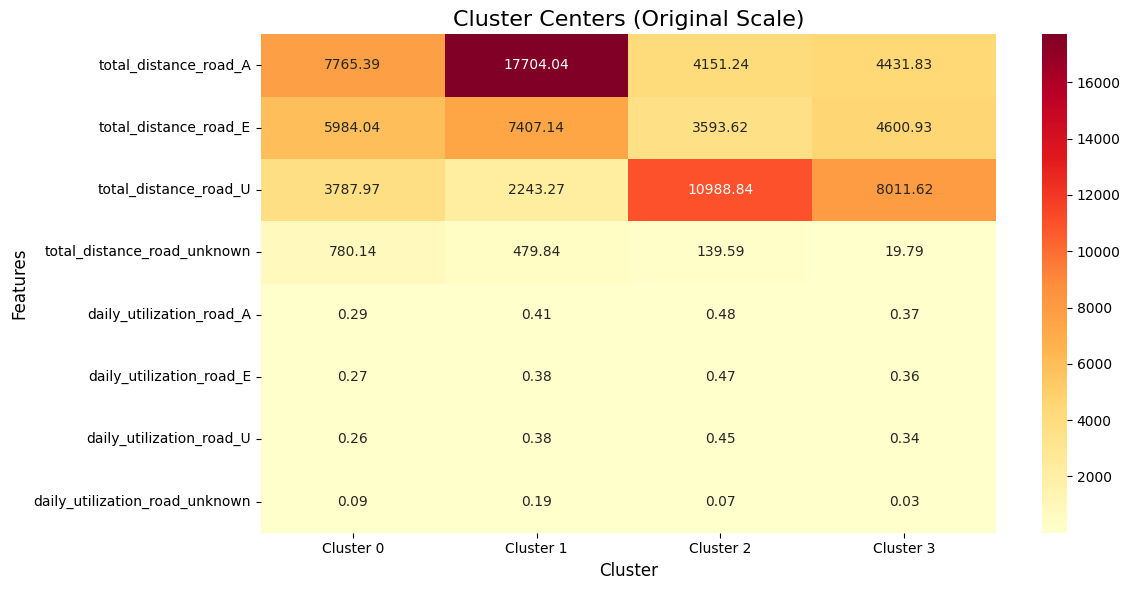

In [84]:
plt.figure(figsize=(12, 6))
sns.heatmap(clusters_rescaled.T, annot=True, fmt='.2f', cmap='YlOrRd', 
            xticklabels=[f'Cluster {i}' for i in range(n_clusters)],
            yticklabels=features)
plt.title('Cluster Centers (Original Scale)', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

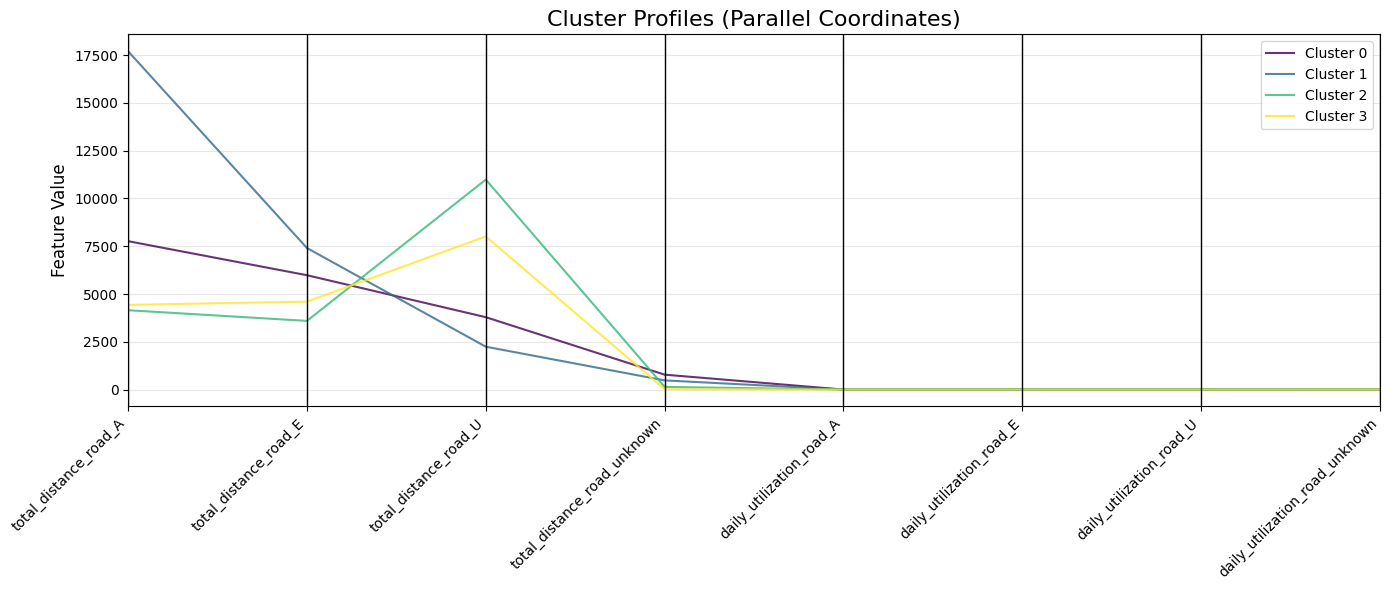

In [85]:
from pandas.plotting import parallel_coordinates

# Prepare data for parallel coordinates
cluster_viz = clusters_rescaled.copy()
cluster_viz['cluster'] = [f'Cluster {i}' for i in range(n_clusters)]

plt.figure(figsize=(14, 6))
parallel_coordinates(cluster_viz, 'cluster', colormap='viridis', alpha=0.8)
plt.title('Cluster Profiles (Parallel Coordinates)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Feature Value', fontsize=12)
plt.legend(loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

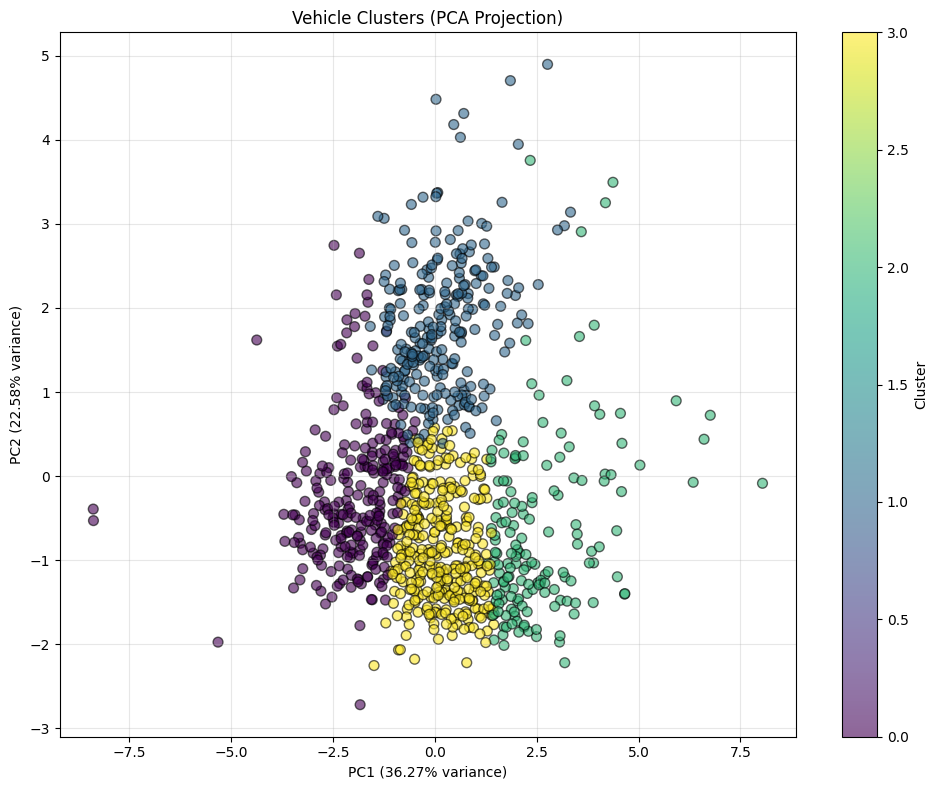

Total variance explained: 58.85%


In [86]:
from sklearn.decomposition import PCA

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
vehicle_data_pca = pca.fit_transform(vehicle_data[features])

# Create scatter plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(vehicle_data_pca[:, 0], vehicle_data_pca[:, 1], 
                     c=vehicle_data['cluster'], cmap='viridis', 
                     s=50, alpha=0.6, edgecolors='k')
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.title('Vehicle Clusters (PCA Projection)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

**2.** Choose at least three EV model from the EV database. Choose and define the evaluation metrics that you want to monitor. The mandatory one is the percentage of feasible trips.

In [52]:
cars = {
    # A - mini
    "Renault Twing E-Tech 27.5 kWh": {
        "Battery_Capacity": "27.5 kWh",
        "AC": {
            "Charge Power": "6.6 kW",
            "Charge Time (0->185 km)": "5h",
            "Charge Speed": "38 km/h"
        },
        "DC": {
            "Charge Power (max)": "50 kW",
            "Charge Power (10-80%)": "40 kW",
            "Charge Time (18->148 km)": "30 min",
            "Charge Speed": "250 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "96 Wh/km",
            "Highway - Mild Weather": "162 Wh/km",
            "Combined - Mild Weather": "128 Wh/km"
        }
    },
    # B - compact
    "Fiat 500e Hatchback 42 kWh": {
        "Battery_Capacity": "37.3 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->235 km)": "4h",
            "Charge Speed": "59 km/h"
        },
        "DC": {
            "Charge Power (max)": "85 kW",
            "Charge Power (10-80%)": "67 kW",
            "Charge Time (23->188 km)": "25 min",
            "Charge Speed": "390 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "105 Wh/km",
            "Highway - Mild Weather": "173 Wh/km",
            "Combined - Mild Weather": "138 Wh/km"
        }
    },
    # C - medium
    "CUPRA Born 170 kW - 77 kWh": {
        "Battery_Capacity": "77.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->450 km)": "8h 15m",
            "Charge Speed": "55 km/h"
        },
        "DC": {
            "Charge Power (max)": "175 kW",
            "Charge Power (10-80%)": "115 kW",
            "Charge Time (0->450 km)": "30 min",
            "Charge Speed": "630 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "118 Wh/km",
            "Highway - Mild Weather": "186 Wh/km",
            "Combined - Mild Weather": "150 Wh/km"
        }
    },
    # D - large
    "BYD SEAL 82.5 kWh RWD Design": {
        "Battery_Capacity": "82.5 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->480 km)": "9h",
            "Charge Speed": "54 km/h"
        },
        "DC": {
            "Charge Power (max)": "150 kW",
            "Charge Power (10-80%)": "100 kW",
            "Charge Time (48->384 km)": "36 min",
            "Charge Speed": "560 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "121 Wh/km",
            "Highway - Mild Weather": "181 Wh/km",
            "Combined - Mild Weather": "149 Wh/km"
        }
    },
    # E - executive
    "BMW iX xDrive40": {
        "Battery_Capacity": "71.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->480 km)": "7h 45m",
            "Charge Speed": "47 km/h"
        },
        "DC": {
            "Charge Power (max)": "148 kW",
            "Charge Power (10-80%)": "102 kW",
            "Charge Time (36->288 km)": "31 min",
            "Charge Speed": "480 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "138 Wh/km",
            "Highway - Mild Weather": "215 Wh/km",
            "Combined - Mild Weather": "175 Wh/km"
        }
    },
    # F - luxury
    "Lotus Eletre S": {
        "Battery_Capacity": "109.0 kWh",
        "AC": {
            "Charge Power": "22 kW",
            "Charge Time (0->480 km)": "6h",
            "Charge Speed": "82 km/h"
        },
        "DC": {
            "Charge Power (max)": "367 kW",
            "Charge Power (10-80%)": "259 kW",
            "Charge Time (48->384 km)": "19 min",
            "Charge Speed": "1060 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "156 Wh/km",
            "Highway - Mild Weather": "242 Wh/km",
            "Combined - Mild Weather": "196 Wh/km"
        }
    },
    # N - passanger van
    "Volkswagen ID. Buzz Pro": {
        "Battery_Capacity": "77.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->405 km)": "8h 15m",
            "Charge Speed": "42 km/h"
        },
        "DC": {
            "Charge Power (max)": "175 kW",
            "Charge Power (10-80%)": "115 kW",
            "Charge Time (34->276 km)": "30 min",
            "Charge Speed": "480 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "154 Wh/km",
            "Highway - Mild Weather": "252 Wh/km",
            "Combined - Mild Weather": "200 Wh/km"
        }
    },
    # S - sport
    "Audi e-tron GT RS": {
        "Battery_Capacity": "85.0 kWh",
        "AC": {
            "Charge Power": "11 kW",
            "Charge Time (0->405 km)": "9h 15m",
            "Charge Speed": "45 km/h"
        },
        "DC": {
            "Charge Power (max)": "268 kW",
            "Charge Power (10-80%)": "216 kW",
            "Charge Time (40->324 km)": "17 min",
            "Charge Speed": "1000 km/h"
        },
        "Energy_Consumption_Rate": {
            "City - Mild Weather": "150 Wh/km",
            "Highway - Mild Weather": "227 Wh/km",
            "Combined - Mild Weather": "185 Wh/km"
        }
    }
}

performance_metrics = {
    "feasibility_metrics": {
        "total_trips": 0,  # Total number of trips,
        "feasible_trips": 0,  # Number of trips completed successfully without running out of battery
        "unfeasible_trips": 0,  # Number of trips needing intervention (out of battery)
        "feasible_trips_percentage": 0.0  # % of trips completed successfully without running out of battery
    },
    "battery_performance_metrics": {
        "avg_soc": 0.0,  # Average State of Charge
        "min_soc": 100.0,  # Minimum SoC reached
        "soc_below_20_count": 0,  # Times battery dropped below 20%
    },
    "charging_behavior_metrics": {
        "total_charging_events": 0,  # Number of charging sessions
        "total_charging_time": 0.0,  # Hours spent charging
        "avg_charging_duration": 0.0,  # Average time per charge
        "fast_charging": 0.0,  # number of fast charging sessions
        "slow_charging": 0.0,  # number of slow charging sessions
        "fast_charging_ratio": 0.0,  # % of fast vs slow charging
        "fast_charging_SoC_threshold": 20.0,  # % SoC - if below this, use fast charging
        "fast_charging_time_threshold": 2  # hours - if parking time < this and SoC < 80%, use fast charging
    },
    "energy_efficiency_metrics": {
        "total_energy_consumed": 0.0,  # kWh consumed
        "avg_energy_per_km": 0.0,  # Wh/km actual consumption
        "total_distance_covered": 0.0  # km successfully driven
    }
}

**3.** Implement the replicator of trips and simulator of EV. Report it with diagram and/or pseudocode.

## Pseudocode for Vehicle Battery Simulation

### Data Preprocessing:

1. Load the dataset (Unipol_dataset_lab3.csv).
2. Sort the data by `vehicle_id` and `start_time`.

### Initialization:

1. Define EV parameters for each model:
    - Battery capacity (kWh)
    - Energy consumption rate (Wh/km)
    - Slow (AC) charging power (kW)
    - Fast (DC) charging power (kW)
2. Initialize metrics dictionary for each vehicle:
    - **Feasibility Metrics:**
        - Total trips count
        - Feasible trips count
        - Unfeasible trips count
        - Feasible trips percentage (mandatory)
    - **Battery Performance Metrics:**
        - Average SoC across all trips
        - Minimum SoC reached
        - Count of SoC below 20%
    - **Charging Metrics:**
        - Total charging events
        - Total charging time (hours)
        - Average charging duration (hours)
        - Slow charging events count
        - Fast charging events count
        - Fast charging ratio (%)
        - Fast charging threshold
    - **Energy & Efficiency Metrics:**
        - Total energy consumed (kWh)
        - Average energy per km (Wh/km)
        - Total distance covered (km)
3. Create data structures for:
    - SoC tracking per trip
    - Charging events log
    - Unfeasible trips details

### Simulation Loop:

**For each EV model:**
1. Initialize results DataFrame to store trip-level data
2. **For each `vehicle_id`:**
    1. Initialize SoC to 100% of the battery capacity
    2. **For each trip in chronological order:**
        1. **Calculate energy required:**
            - `energy_needed = total_distance * energy_consumption_rate`
        2. **Check trip feasibility:**
            - If `current_SoC >= energy_needed`:
                - Deduct energy: `new_SoC = current_SoC - energy_needed`
                - Record trip as **feasible**
                - Update metrics:
                    - Increment feasible_trips count
                    - Add energy_needed to total_energy_consumed
                    - Add distance to total_distance_covered
                    - If `new_SoC < 20% of battery_capacity`:
                        - Increment soc_below_20_count
            - Else:
                - Record trip as **unfeasible**
                - Increment unfeasible_trips count
                - Log unfeasible trip details
        3. **Calculate parking duration until next trip:**
            - get the next trip of the vehicle, if exists, else skip to next vehicle
            - `parking_time = next_trip_start_time - current_trip_end_time`
        4. **Charging logic (if parking time > 0):**
            1. Determine charging type:
                - If `current_SoC < fast_charging_SoC_threshold * battery_capacity`:
                    - Use fast charging power
                    - Increment fast_charging count
                    - `charging_power = fast_charging_power (DC)`
                - Elif `parking_time < fast_charging_time_threshold` and `current_SoC < 80%`:
                    - Use fast charging power
                    - Increment fast_charging count
                    - `charging_power = fast_charging_power (DC)`
                - Else:
                    - Use slow charging power
                    - Increment slow_charging count
                    - `charging_power = slow_charging_power (AC)`
            2. Calculate energy recharged:
                - `energy_needed_to_full = battery_capacity - current_SoC`
                - `time_to_full = energy_needed_to_full / charging_power`
                - `actual_charging_time = min(parking_time, time_to_full)`
                - `energy_recharged = charging_power * actual_charging_time`
                - `new_SoC = min(current_SoC + energy_recharged, battery_capacity)`
            3. Update charging metrics:
                - Increment total_charging_events
                - Add `actual_charging_time` to total_charging_time
        5. **Store trip results:**
            - Trip ID, SoC before, SoC after, feasibility, energy consumed
3. **Aggregate vehicle-level metrics:**
    - Calculate percentages and averages from accumulated counts

### Metrics Calculation:

**For each EV model, calculate:**

1. **Feasibility:**
    - `feasible_trips_percentage = (feasible_trips / total_trips) * 100`
2. **Battery Performance:**
    - `avg_soc = mean(all_SoC_values)`
    - `min_soc = min(all_SoC_values)`
3. **Charging:**
    - `avg_charging_duration = total_charging_time / total_charging_events`
    - `fast_charging_ratio = (fast_charging / total_charging_events) * 100`
4. **Energy Efficiency:**
    - `avg_energy_per_km = (total_energy_consumed * 1000) / total_distance_covered` (Wh/km)

### Comparison & Analysis:

1. Create comparison DataFrame with all EV models and their metrics
2. Identify best-performing EV for each metric category
3. Analyze trade-offs (e.g., range vs charging speed vs cost)

### Visualization:

1. **Feasibility Comparison:**
    - Bar chart: Feasible trips percentage per EV model
    - Bar chart: Unfeasible trips count per EV model
2. **Battery SoC Over Time:**
    - Line plot: SoC evolution for sample vehicles from each model
    - Distribution plot: SoC distribution across all trips
3. **Charging Analysis:**
    - Bar chart: Total charging events per EV model
    - Pie chart: Fast vs Slow charging ratio per model
    - Histogram: Charging duration distribution
4. **Energy Efficiency:**
    - Bar chart: Average energy consumption (Wh/km) per model
    - Scatter plot: Energy consumption vs distance per trip
5. **Comprehensive Dashboard:**

    - Heatmap: All metrics normalized across EV models
    - Radar chart: Multi-metric comparison of EV models